In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 22 16:26:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from PIL import Image
import numpy as np
import os
import h5py
import pandas as pd
import torch
import math
import torch.nn as nn
import torchvision
import time
import random
#import torchviz
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, Dataset, sampler, SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import cv2 as cv
import warnings
warnings.filterwarnings('ignore')
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors

In [0]:
hf = h5py.File('/content/drive/My Drive/UTK/data.h5', 'r')
hf.keys()

<KeysViewHDF5 ['Gender', 'age', 'images']>

In [0]:
images = hf['images']
age = hf['age']
gender = hf['Gender']

In [0]:
age_dict = {0: '0-25', 1:'25-50', 2:'50-75', 3:'75-'}
gender_dict = {0 : 'Male', 1: 'Female'}

In [0]:
image_ids = list(range(0, len(images)))
random.Random(4).shuffle(image_ids)
valid_size = 0.8
train_ids = image_ids[:int(np.floor(valid_size*len(image_ids)))]
train_ids.sort()
valid_ids = image_ids[int(np.floor(valid_size*len(image_ids))):]
valid_ids.sort()

In [0]:
train_images = images[train_ids]
train_age = age[train_ids]
train_gender = gender[train_ids]

valid_images = images[valid_ids]
valid_age = age[valid_ids]
valid_gender = gender[valid_ids]

In [0]:
class ImageDataset(Dataset):
  def __init__(self, images, age, gender, transform=None):
    self.images = images
    self.transform = transform
    self.age = age
    self.gender = gender
  
  def __getitem__(self, idx):
    img =  self.images[idx]
    img = Image.fromarray(img.astype(np.uint8))
    img = img.resize((224, 224))
    #img = np.array(img)
    age = self.age[idx]
    if age >=0 and age <25:
      age = 0
    elif age >=25 and age < 50:
      age = 1
    elif age >=50 and age < 75:
      age = 2
    else:
      age = 3
    Gender = self.gender[idx]
    #Ethnicity = int(img_id.split('_')[2])
    if self.transform:
      img = self.transform(img)
    
    return img, age, Gender
  
  def __len__(self):
    return len(self.age)

In [0]:
train_transformations = transforms.Compose([
   # transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.70832765, 0.5542221 , 0.487289), (0.22306082, 0.22076079, 0.22623643))
])
valid_transformation = transforms.Compose([
  #  transforms.CenterCrop(224),                                     
    transforms.ToTensor(),
    transforms.Normalize((0.70832765, 0.5542221 , 0.487289), (0.22306082, 0.22076079, 0.22623643))
])
imageloader = ImageDataset(train_images,train_age, train_gender, transform= train_transformations)
train_loader = DataLoader(imageloader,batch_size=128,shuffle=True)
imageloader_t = ImageDataset(valid_images,valid_age, valid_gender,  transform= valid_transformation)
valid_loader = DataLoader(imageloader_t,batch_size=128,shuffle=False)

In [0]:
class AgeGenderModel(nn.Module):
  def __init__(self, output_size, age_output, fine_tune=False, dropout = 0.4):
    super(AgeGenderModel, self).__init__()
    self.output_size = output_size
    self.age_outupt = age_output
    #elf.age_dict = age_dict
    self.resnet152 = models.resnet101(pretrained=True)
    num_ftrs = self.resnet152.fc.in_features
    for p in self.resnet152.parameters():
        p.requires_grad = fine_tune
    self.resnet152.fc = nn.Identity()
    self.fc1 = nn.Linear(num_ftrs, output_size)
    self.fc2 = nn.Linear(num_ftrs, age_output)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    x = self.resnet152(x)
    gender = self.fc1(x)
    #g = g.unsqueeze(-1).float()
    #gender_ = gender.argmax(dim=1)
    #gender_ = gender_.unsqueeze(-1).float()
    x = self.dropout(x)
    age = self.fc2(x)
    return gender, age

In [0]:
model = AgeGenderModel(2, 4)
model = model.to(device)
gender_loss = nn.CrossEntropyLoss().to(device)
age_loss = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer =torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
num_epochs = 100
f = 0
train_loss_age = []
train_loss_gender = []
valid_loss_age = []
valid_loss_gender = []
for epoch in range(num_epochs):
  if f < 5:
    train_loss_g = 0
    train_loss_v = 0  
    valid_loss_g = 0
    valid_loss_v = 0
    valid_loss_a = 0
    valid_loss_min = 10000
    model.train()
  #  model = model.double()
    start = time.time()
    for img, age, gender in train_loader:
      #img, age, gender = img.type(torch.DoubleTensor),
      gender = gender.type(torch.LongTensor)
      age = age.type(torch.LongTensor) 
      optimizer.zero_grad()
      img = img.to(device)
      age = age.to(device)
      gender = gender.to(device)
 
      gender_p, age_p = model(img)
      gender_l = gender_loss(gender_p, gender)
      #print(gender_l)
      age_l = age_loss(age_p, age)
      #print(age_l)
      loss = 0.3*gender_l+0.7*age_l
      loss.backward()
      optimizer.step()
      train_loss_g += gender_l.item()
      train_loss_v += age_l.item()
    train_loss_age.append(train_loss_v/len(train_loader))
    train_loss_gender.append(train_loss_g/len(train_loader))
    print('Epoch:  ' + str(epoch) + '        train loss_gender:  ' + str(train_loss_g/len(train_loader))+ '        train_loss_age:  ' + str(train_loss_v/len(train_loader)))

    model.eval()
    for img_v, age_v, gender_v in valid_loader:
      gender_v = gender_v.type(torch.LongTensor)
      age_v = age_v.type(torch.LongTensor) 
      img_v = img_v.to(device)
      age_v = age_v.to(device)
      gender_v = gender_v.to(device)
      gender_pv, age_pv = model(img_v)
      gender_lv = gender_loss(gender_pv, gender_v)
      age_lv = age_loss(age_pv, age_v)
      valid_loss_g += gender_lv.item()
      valid_loss_a += age_lv.item()
      valid_loss_v = valid_loss_g+valid_loss_a
    if valid_loss_v < valid_loss_min:
      valid_loss_min = valid_loss_v
      f = 0
      print('saving model')
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/My Drive/UTK/model_age_gender_100_wg_enf.pt')
    else:
      f+=1
    valid_loss_age.append(valid_loss_a/len(valid_loader))
    valid_loss_gender.append(valid_loss_g/len(valid_loader))
    print('Epoch:  ' + str(epoch) + '        valid loss_gender:  ' + str(valid_loss_g/len(valid_loader))+ '        valid_loss_age:  ' + str(valid_loss_a/len(valid_loader)))

In [0]:
files = os.listdir('/content/drive/My Drive/crop_faces/')
#0, 2, 3, 8, 9, 10, 11, 13, -1

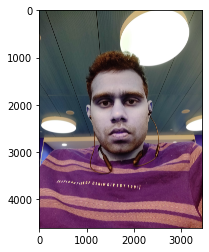

In [0]:
face_cascade = cv.CascadeClassifier('/content/drive/My Drive/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('/content/drive/My Drive/haarcascades/haarcascade_eye.xml')
img = cv.imread('/content/drive/My Drive/crop_faces/' +files[-1])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
x,y,w,h = faces[0]
im = img[x-20:x+w+20, y-20:y+h+20]
plt.imshow(img)

In [0]:
model.eval()
im = Image.fromarray(im)
im = im.resize((224,224))
im_ = transforms.ToTensor()(im)
im_ = transforms.Normalize((0.70832765, 0.5542221 , 0.487289), (0.22306082, 0.22076079, 0.22623643))(im_)
im_ = im_.unsqueeze(0)
im_ = im_.to(device)
gender,age = model(im_)

In [0]:
print('gender:    '+  gender_dict[gender.argmax(dim=1).tolist()[0]])
print('age:       '+ age_dict[age.argmax(dim=1).tolist()[0]])

gender:    Male
age:       0-25


In [0]:
# checkpoint = torch.load('/content/drive/My Drive/UTK/model_age_gender_100_wg_enf.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [0]:
train_pre_g, train_pre_a = [], []
valid_pre_g, valid_pre_a = [], []
train_g, train_a = [], []
valid_g, valid_a = [], []
model.eval()
for img, age, gender in train_loader:
  train_a.extend(age.cpu().tolist())
  train_g.extend(gender.cpu().tolist())
  #img, age, gender = img.type(torch.DoubleTensor),
  gender = gender.type(torch.LongTensor)
  age = age.type(torch.LongTensor) 
  img = img.to(device)
  age = age.to(device)
  gender = gender.to(device)
  gender_p, age_p = model(img)
  train_pre_a.extend(age_p.argmax(dim=1).cpu().tolist())
  train_pre_g.extend(gender_p.argmax(dim=1).cpu().tolist())


for img, age, gender in valid_loader:
  valid_a.extend(age.cpu().tolist())
  valid_g.extend(gender.cpu().tolist())
  #img, age, gender = img.type(torch.DoubleTensor),
  gender = gender.type(torch.LongTensor)
  age = age.type(torch.LongTensor) 
  img = img.to(device)
  age = age.to(device)
  gender = gender.to(device)
  gender_p, age_p = model(img)
  valid_pre_a.extend(age_p.argmax(dim=1).cpu().tolist())
  valid_pre_g.extend(gender_p.argmax(dim=1).cpu().tolist())

In [0]:
print('Train gender accuracy    ' + str(sum(np.array(train_pre_g) == np.array(train_g))/len(train_g)))
print('valid gender accuracy    ' + str(sum(np.array(valid_pre_g) == np.array(valid_g))/len(valid_g)))

print('Train Age accuracy      '+ str(sum(np.array(train_pre_a) == np.array(train_a))/len(train_a)))
print('valid age accuracy    ' + str(sum(np.array(valid_pre_a) == np.array(valid_a))/len(valid_a)))

Train gender accuracy    0.8586417800274175
valid gender accuracy    0.8435259384226065
Train Age accuracy      0.6845934830749763
valid age accuracy    0.6739772247996626


In [0]:
from sklearn.metrics import confusion_matrix
acc_per_class = {}
k = confusion_matrix(train_pre_a, train_a)
for i in range(0, 4):
  acc_per_class[i] = k[i, i]/k.sum(axis=1)[i]

In [0]:
pd.DataFrame(k)

,0,1,2,3
0,3429,844,164,13
1,2119,8528,2247,238
2,9,74,628,135
3,1,5,133,399


In [0]:
acc_per_class_v = {}
k = confusion_matrix(valid_pre_a, valid_a)
for i in range(0, 4):
  acc_per_class_v[i] = k[i, i]/k.sum(axis=1)[i]

In [0]:
pd.DataFrame(k)

,0,1,2,3
0,826,219,48,4
1,518,2120,572,64
2,1,22,152,48
3,0,4,46,98


In [0]:
acc_per_class_v

{0: 0.7529626253418414,
 1: 0.6475259621258399,
 2: 0.6816143497757847,
 3: 0.6621621621621622}

In [0]:
acc_per_class

{0: 0.770561797752809,
 1: 0.6494060310691441,
 2: 0.7423167848699763,
 3: 0.741635687732342}

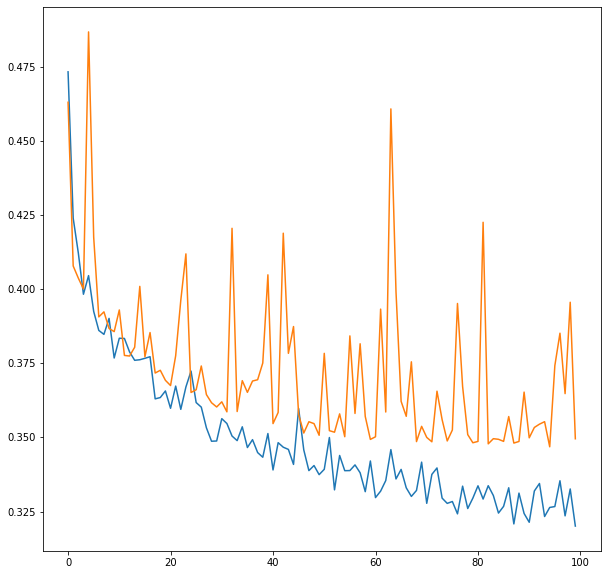

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
epochs = [f for f in range(0,100)]
plt.plot(epochs, train_loss_gender)
plt.plot(epochs, valid_loss_gender)

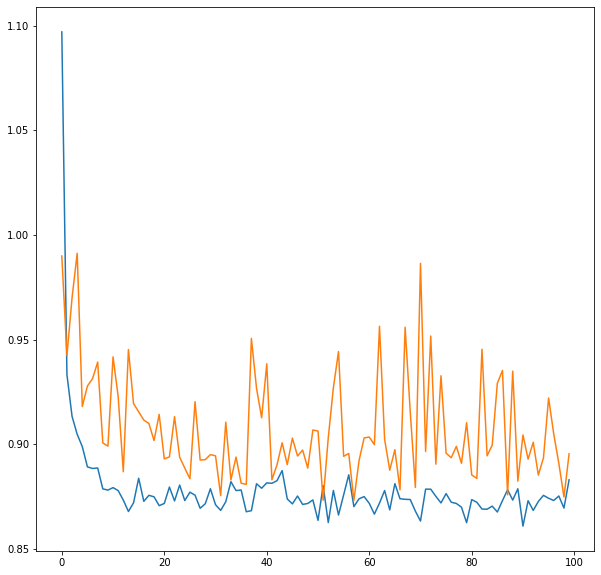

In [0]:
plt.figure(figsize=(10,10))
epochs = [f for f in range(0,100)]
plt.plot(epochs, train_loss_age)
plt.plot(epochs, valid_loss_age)

In [0]:
checkpoint = {'model': AgeGenderModel(2,len(ag_), age_dict=age_dict),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(), 
          'epochs' : epoch}

torch.save(checkpoint, '/content/drive/My Drive/Gender_age_103.pth')

In [0]:
# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = checkpoint['model']
#     model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False

#     model.eval()
#     return model

# model = load_checkpoint('/content/drive/My Drive/UTK/model_age_gender_100_wg_enf.pt')